<a href="https://colab.research.google.com/github/MukhlasAdib/KITTI_Mapping/blob/main/KITTI_Mapping_Tutorial_Step_by_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# References

[1] Repository for this tutorial: https://github.com/MukhlasAdib/KITTI_Mapping.

[2] The full KITTI datased can be accessed here: http://www.cvlibs.net/datasets/kitti/.

[3] KITTI Dataset paper: A. Geiger, P. Lenz, C. Stiller and R. Urtasun, "Vision meets Robotics: The KITTI Dataset," *International Journal of Robotics Research (IJRR)*, vol. 32, no. 11, pp. 1231-1237 2013.

[4] Description of Occupancy Grid Map (OGM) estimation: Z. Luo, M. V. Mohrenschilt and S. Habibi, "A probability occupancy grid based approach for real-time LiDAR ground segmentation," *IEEE Transactions on Intelligent Transportation Systems*, vol 21, no. 3, pp. 998–1010, Mar. 2020.

[5] Description of Dynamic Grid Map (DGM) estimation: J. Moras, V. Cherfaoui and P. Bonnifait, "Credibilist occupancy grids for vehicle perception in dynamic environments," *2011 IEEE International Conference on Robotics and Automation*, Shanghai, China, 2011, pp. 84-89.

[6] Paper of DeepLab v3+ for image segmentation: L. C. Chen, Y. Zhu, G. apandreou, F. Schroff and H. Adam, “Encoder-decoder with atrous separable convolution for semantic image segmentation,” *ECCV 2018 Lecture Notes in Computer Science*, vol. 11211, pp. 833–851, 2018.

[7] DeepLab v3+ paper via arXiv: https://arxiv.org/abs/1802.02611.

[8] DeepLab v3+ repository: https://github.com/tensorflow/models/tree/master/research/deeplab.

[9] This tutorial use pykitti module to load the KITTI dataset: https://github.com/utiasSTARS/pykitti.

# PREPARATION

In [1]:
!git clone https://github.com/MukhlasAdib/KITTI_Mapping.git
!pip install pykitti

Cloning into 'KITTI_Mapping'...
remote: Enumerating objects: 906, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 906 (delta 3), reused 7 (delta 1), pack-reused 894
Receiving objects: 100% (906/906), 497.56 MiB | 31.00 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Checking out files: 100% (879/879), done.


In [2]:
import os
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pykitti
import tensorflow as tf
from sklearn.linear_model import RANSACRegressor
from scipy import stats

In [3]:
### Load KITTI Data
basedir = 'KITTI_Mapping/raw_data/'
date = '2011_09_26'
drive = '0013'
data = pykitti.raw(basedir, date, drive)

### Index of data used for test
### We use two data from different time
idx = 50
idx1 = idx+10

# PERCEPTION

The goal of the perception system is to extract the information about the round where the vehicle is operating on. This road information will be used to filter out LiDAR points that hit the road so that it can be used for mapping purpose. To extract the information about where the road is, we use deep learning-based image segmentation technique that will be applied to the camera image.

## Get Callibration Data

Two callibrated parameters that we need:
- LiDAR to camera extrinsic matrix - The matrix (4x4) that will be used to transform the LiDAR points to the camera 3D coordinate frame.
-  Camera intrinsic matrix - The mastrix (3x3) that will be used to calculate the coordinate of pixels that representat 3D points in camera coordinate.

The calibrated parameters are already provided in the dataset. For details, please visit [this explanation](https://www.mathworks.com/help/vision/ug/camera-calibration.html) from Mathworks

In [4]:
### Retrieve the provided calibration data
lidar2cam_extrinsic = data.calib.T_cam2_velo
camera_intrinsic = data.calib.K_cam2

print('Lidar to camera extrinsic matrix: ')
print(lidar2cam_extrinsic)
print()
print('Camera intrinsic matrix: ')
print(camera_intrinsic)

Lidar to camera extrinsic matrix: 
[[ 2.34773698e-04 -9.99944155e-01 -1.05634778e-02  5.93721868e-02]
 [ 1.04494074e-02  1.05653536e-02 -9.99889574e-01 -7.51087914e-02]
 [ 9.99945389e-01  1.24365378e-04  1.04513030e-02 -2.72132796e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Camera intrinsic matrix: 
[[721.5377   0.     609.5593]
 [  0.     721.5377 172.854 ]
 [  0.       0.       1.    ]]


## Load Camera and LiDAR Data

Coordinate system of
- Camera = x: right, y: down, z: forward
- LiDAR = x: forward, y: left, z: up

In this tutorial, camera coordinate system is used. Therefore, the LiDAR points need to be transformed to the camera coordinate frame. Use the LiDAR to camera extrinsic matrix!

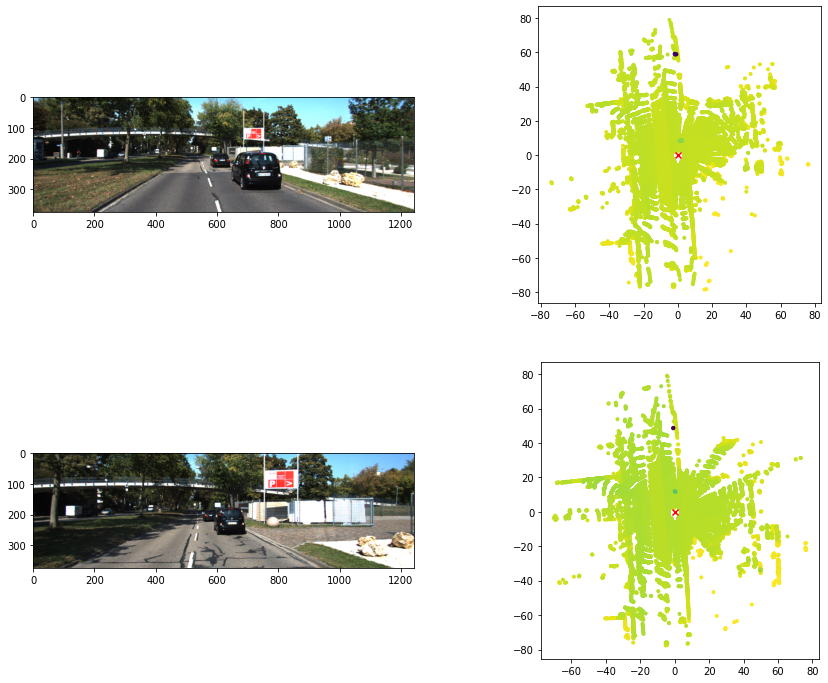

In [5]:
def load_data(data,idx):
  ### Get the image data
  img_raw = np.array(data.get_cam2(idx))

  ### Get the LiDAR data (only x,y,z data)
  ### Only use LiDAR points that are below the sensor
  ### Only use LiDAR points that are at least 2.5 m away
  lidar_raw = np.array(data.get_velo(idx))[:,:3]
  lidar_raw = lidar_raw[lidar_raw[:,2]<=0,:]
  dist = np.linalg.norm(lidar_raw,axis=1)
  lidar_raw = lidar_raw[dist >= 2.5]
  return img_raw,lidar_raw

### Transform the LiDAR points into camera coordinate
def transform_coordinate(lidar_points,extrinsic_matrix):
  inp = lidar_points.copy()
  inp = np.concatenate((inp,np.ones((inp.shape[0],1))),axis=1)
  inp = np.matmul(extrinsic_matrix,inp.T).T
  return inp[:,:3]

img_raw,lidar_raw = load_data(data,idx)
img_raw_size = img_raw.shape
lidar_raw = transform_coordinate(lidar_raw,lidar2cam_extrinsic)

img_raw1,lidar_raw1 = load_data(data,idx1)
img_raw1_size = img_raw1.shape
lidar_raw1 = transform_coordinate(lidar_raw1,lidar2cam_extrinsic)

### Visualize
fig,axs = plt.subplots(2,2,figsize=(15,12))
axs[0,0].imshow(img_raw)
axs[0,1].scatter(lidar_raw[:,0],lidar_raw[:,2],c=-lidar_raw[:,1],marker='.')
axs[0,1].scatter(0,0,c='r',marker='x')
axs[0,1].axis('scaled')
axs[1,0].imshow(img_raw1)
axs[1,1].scatter(lidar_raw1[:,0],lidar_raw1[:,2],c=-lidar_raw1[:,1],marker='.')
axs[1,1].scatter(0,0,c='r',marker='x')
axs[1,1].axis('scaled')
plt.show()

## Project the LiDAR Points to the Camera

To transfer the road information from image to LiDAR, we need to project the LiDAR points to the camera image. Use the camera intrinsic matrix!

Original image size: (375, 1242, 3)


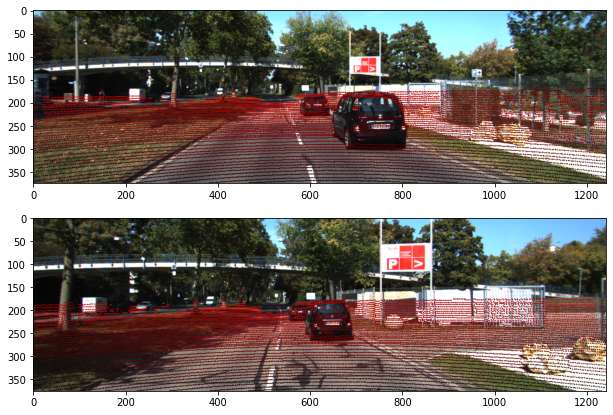

In [6]:
def project_lidar2cam(lidar_in_cam,camera_intrinsic,img_raw_size):
  ### Filter out data behind the cam
  lidar_in_cam = np.concatenate((lidar_in_cam,np.ones((lidar_in_cam.shape[0],1))),axis=1)
  lidar_in_cam = lidar_in_cam[lidar_in_cam[:,2]>0]

  ### Project points to the image
  lidar_2d = np.matmul(camera_intrinsic,lidar_in_cam[:,:3].T).T
  lidar_2d = np.divide(lidar_2d,lidar_2d[:,2].reshape((-1,1)))
  lidar_2d = lidar_2d.astype(int)

  ### Filter out points that are outside image frame
  maskH = np.logical_and(lidar_2d[:,0]>=0,lidar_2d[:,0]<img_raw_size[1])
  maskV = np.logical_and(lidar_2d[:,1]>=0,lidar_2d[:,1]<img_raw_size[0])
  mask = np.logical_and(maskH,maskV)
  lidar_2d = lidar_2d[mask,:]
  lidar_in_cam = lidar_in_cam[mask,:]

  return lidar_2d,lidar_in_cam[:,:3]

lidar_2d,lidar_in_cam = project_lidar2cam(lidar_raw,camera_intrinsic,img_raw_size)
lidar_2d1,lidar_in_cam1 = project_lidar2cam(lidar_raw1,camera_intrinsic,img_raw_size)

### Visualize
print(f'Original image size: {img_raw.shape}')

img = img_raw.copy()
axs = 2
axs_log = np.log(lidar_in_cam[:,axs]-np.min(lidar_in_cam[:,axs])+1)
max_axs = np.max(axs_log)
for pt,z in zip(lidar_2d,axs_log):
    color_z = z*255/max_axs
    c = (color_z,0,0)
    cv2.circle(img,tuple(pt[:2].astype(int)),1,c,-1)

img1 = img_raw1.copy()
axs = 2
axs_log1 = np.log(lidar_in_cam1[:,axs]-np.min(lidar_in_cam1[:,axs])+1)
max_axs1 = np.max(axs_log1)
for pt,z in zip(lidar_2d1,axs_log1):
    color_z = z*255/max_axs1
    c = (color_z,0,0)
    cv2.circle(img1,tuple(pt[:2].astype(int)),1,c,-1)

fig,axs = plt.subplots(2,1,figsize=(15,7))
axs[0].imshow(img)
axs[1].imshow(img1)
plt.show()

## Image Cropping

The deep learning model (DeepLab v3+) was trained with cropped images from KITTI dataset with ratio 4:3 (W:H), which was resized further to 513 x 513 images. It will work better if we use the same size of images.

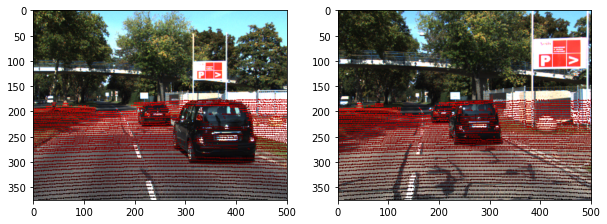

In [7]:
### Function to crop the image according to the target size ratio
### The image will be cropped at the center
def crop_data(img_in,lidar_2d_in,lidar_in_cam_in,rh,rw):
  lidar_2d = lidar_2d_in.copy()
  lidar_in_cam = lidar_in_cam_in.copy()
  img = img_in.copy()

  ### Crop the image
  dim_ori = np.array(img.shape)
  cent = (dim_ori/2).astype(int)
  if dim_ori[0]/dim_ori[1] == rh/rw:
      crop_img = img
    
  # If Height <= Width
  elif dim_ori[0] <= dim_ori[1]:
      cH2 = dim_ori[0]
      cW2 = cH2*rw/rh
      cW = int(cW2/2)
      crop_img = img[:,cent[1]-cW:cent[1]+cW+1]

  # If Height > Width
  else:
      cW2 = dim_ori[1]
      cH2 = cW2*rh/rw
      cH = int(cH2/2)
      crop_img = img[cent[0]-cH:cent[0]+cH+1,:]

  ### Filter out LiDAR points outside cropped image
  cW = cW2/2
  cH = cH2/2
  centH = cent[0]
  centW = cent[1]
  maskH = np.logical_and(lidar_2d[:,1]>=centH-cH,lidar_2d[:,1]<=centH+cH)
  maskW = np.logical_and(lidar_2d[:,0]>=centW-cW,lidar_2d[:,0]<=centW+cW)
  mask = np.logical_and(maskH,maskW)
  lidar_2d = lidar_2d[mask,:]
  lidar_in_cam = lidar_in_cam[mask,:]
  cent = np.array((centW-cW,centH-cH,0)).reshape((1,3))
  lidar_2d = lidar_2d - cent

  return crop_img, lidar_2d.astype(int), lidar_in_cam

### Cropped image's size ratio
CROP_RH = 3 # Height ratio
CROP_RW = 4 # Width ratio
crop_img,lidar_2d,lidar_in_cam = crop_data(img_raw,lidar_2d,lidar_in_cam,CROP_RH,CROP_RW)
crop_img1,lidar_2d1,lidar_in_cam1 = crop_data(img_raw1,lidar_2d1,lidar_in_cam1,CROP_RH,CROP_RW)

### Visualize
img = crop_img.copy()
axs = 2
axs_log = np.log(lidar_in_cam[:,axs]-np.min(lidar_in_cam[:,axs])+1)
max_axs = np.max(axs_log)
for pt,z in zip(lidar_2d,axs_log):
    color_z = z*255/max_axs
    c = (color_z,0,0)
    cv2.circle(img,tuple(pt[:2].astype(int)),1,c,-1)

img1 = crop_img1.copy()
axs = 2
axs_log1 = np.log(lidar_in_cam1[:,axs]-np.min(lidar_in_cam1[:,axs])+1)
max_axs1 = np.max(axs_log1)
for pt,z in zip(lidar_2d1,axs_log1):
    color_z = z*255/max_axs1
    c = (color_z,0,0)
    cv2.circle(img1,tuple(pt[:2].astype(int)),1,c,-1)

fig,axs = plt.subplots(1,2,figsize=(10,7))
axs[0].imshow(img)
axs[1].imshow(img1)
plt.show()

## Road Segmentation

Process the camera image with image segmentation-based deep learning method to get regions that correspond to the road. Specifically, we use DeepLab v3+ model that has been trained before with KITTI dataset. [Read this article](https://rockyshikoku.medium.com/train-deeplab-v3-with-your-own-dataset-13f2af958a75) if you want to know how to train your own DeepLab v3+ model. 

Now, by projecting the LiDAR points to the segmented image, we can know which points that correspond to the road. 

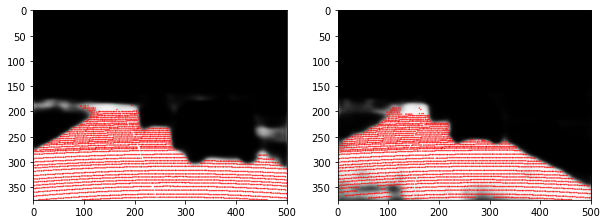

In [8]:
### Function to process the image with DeepLabv3+
def process_images(img_in, sess, target_size=513, probability_threshold=0.5):
  INPUT_TENSOR_NAME = 'ImageTensor:0'
  PROB_TENSOR_NAME = 'SemanticProbabilities:0'
  INPUT_SIZE = target_size

  image = img_in.copy()
  sz = image.shape
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Resize input image to target size
  if INPUT_SIZE == 0:
    resized_image = image.copy()
  else:
    resized_image = cv2.resize(image,(INPUT_SIZE,INPUT_SIZE))

  # Run deep learning inference
  batch_seg_map = sess.run(
      PROB_TENSOR_NAME,
      feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
  seg_map = (batch_seg_map[0][:,:,1]*255).astype(int)
  prob = np.array(seg_map, dtype=np.uint8)
  prob = cv2.resize(prob,(sz[1],sz[0]))

  # Create the prediction
  pred = prob.copy()
  msk_bin = prob >= (probability_threshold*255)
  pred[msk_bin] = 1
  pred[np.logical_not(msk_bin)] = 0

  # Ignore regions that are separated from the main road
  # This can reduce the amount of false detection
  _,segm_reg = cv2.connectedComponents(pred)
  segm_reg = segm_reg.astype(float)
  segm_reg[segm_reg==0] = np.nan
  modes,_ = stats.mode(segm_reg,axis=None)
  mode = modes[0]
  pred[segm_reg!=mode] = 0
  
  return prob,(pred*255).astype(np.uint8)

### Load the model
model_path = 'KITTI_Mapping/pretrained/deeplab_model.pb'
with open(model_path, "rb") as f:
    graph_def = tf.compat.v1.GraphDef.FromString(f.read())
graph = tf.Graph()
with graph.as_default():
    tf.import_graph_def(graph_def=graph_def, name="")
sess = tf.compat.v1.Session(graph=graph)

target_size = 513
segm_prob,segm_pred = process_images(crop_img, sess, target_size, 0.5)
segm_prob1,segm_pred1 = process_images(crop_img1, sess, target_size, 0.5)

### Visualize
segm_3ch = crop_img.copy()
segm_3ch[:,:,0] = segm_prob
segm_3ch[:,:,1] = segm_prob
segm_3ch[:,:,2] = segm_prob
for pt in lidar_2d:
  pt = pt.astype(int)
  if segm_pred[pt[1],pt[0]] == 0:
    continue
  c = (255,0,0)
  cv2.circle(segm_3ch,tuple(pt[:2]),1,c,-1)

segm_3ch1 = crop_img1.copy()
segm_3ch1[:,:,0] = segm_prob1
segm_3ch1[:,:,1] = segm_prob1
segm_3ch1[:,:,2] = segm_prob1
for pt in lidar_2d1:
  pt = pt.astype(int)
  if segm_pred1[pt[1],pt[0]] == 0:
    continue
  c = (255,0,0)
  cv2.circle(segm_3ch1,tuple(pt[:2]),1,c,-1)

fig,axs = plt.subplots(1,2,figsize=(10,7))
axs[0].imshow(segm_3ch)
axs[1].imshow(segm_3ch1)
plt.show()

## LiDAR Road Filter

The road points set that are obtained from the previous step may contain false detection and obviously only contains point that are inside the camera field of view. We also need to detect road points that are outside this set!

To do this, fit a plane model (which will represent the road model) to the current road points. Any points that are outside the camera field of view and located near the road plane model can be also regarded as road points. RANSAC algorithm is applied when fitting the model to reduce the influence of outliers. Visit this [Wikipedia page](https://en.wikipedia.org/wiki/Random_sample_consensus) for more information about RANSAC.

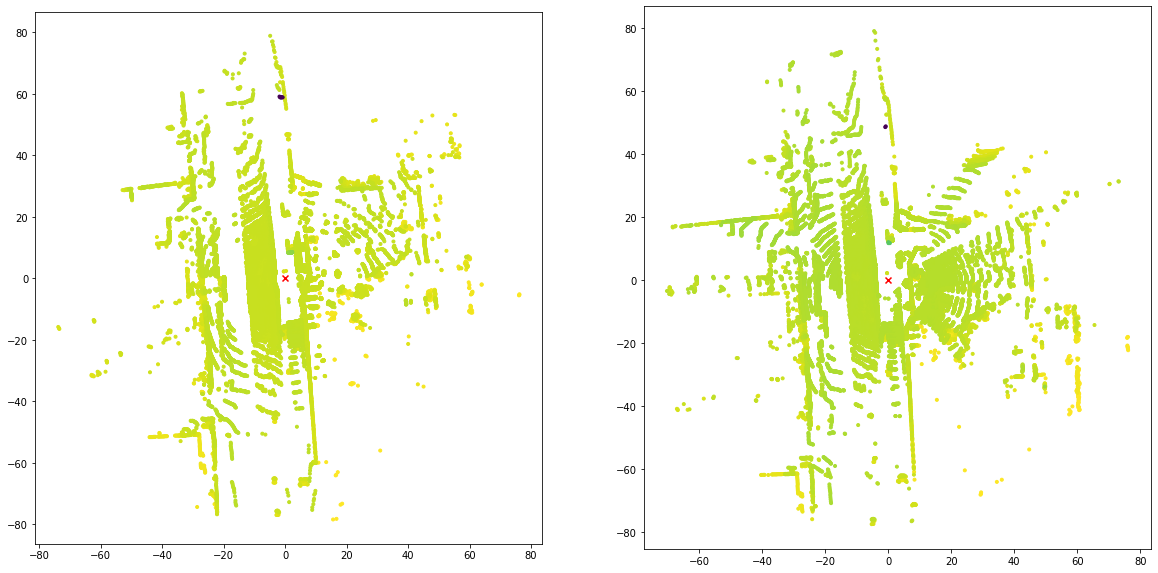

In [9]:
### Get the plane model from the road points
def get_road_model_ransac(img_pred,lidar_in_cam,lidar_2d):
  lidar_in_road_lbl = [True if img_pred[pt[1],pt[0]] == 255 else False for pt in lidar_2d]
  lidar_in_road = lidar_in_cam[lidar_in_road_lbl,:]
  road_model = RANSACRegressor().fit(lidar_in_road[:,[0,2]],lidar_in_road[:,1])
  return road_model

### Predict all LiDAR points as road or not
def filter_road_points(road_model,lidar_in,threshold=0.5):
  x = lidar_in[:,[0,2]]
  y_true = lidar_in[:,1]
  y_pred = road_model.predict(x)
  delta_y = np.absolute(y_true-y_pred).flatten()
  is_not_road = delta_y > threshold
  lidar_out = lidar_in[is_not_road,:].copy()
  return lidar_out

road_height_threshold = 0.1

road_model = get_road_model_ransac(segm_pred,lidar_in_cam,lidar_2d)
lidar_nonroad = filter_road_points(road_model,lidar_raw,road_height_threshold)

road_model1 = get_road_model_ransac(segm_pred1,lidar_in_cam1,lidar_2d1)
lidar_nonroad1 = filter_road_points(road_model1,lidar_raw1,road_height_threshold)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(20,10))
axs[0].scatter(lidar_nonroad[:,0],lidar_nonroad[:,2],c=-lidar_nonroad[:,1],marker='.')
axs[0].scatter(0,0,c='r',marker='x')
axs[0].axis('scaled')
axs[1].scatter(lidar_nonroad1[:,0],lidar_nonroad1[:,2],c=-lidar_nonroad1[:,1],marker='.')
axs[1].scatter(0,0,c='r',marker='x')
axs[1].axis('scaled')
plt.show()

Now we can remove the road points from the LiDAR data and proceed to the mapping system.

# MAPPING (OGM)

The occupancy grid map 

## Parameters

In [10]:
ALPHA = 1
BHETA = 1*np.pi/180
RESOLUTION = 0.1
MAX_RANGE = 50
MAP_WIDTH = 100
SPHERICAL2CARTESIAN_BIAS = 6

## Map Initialization

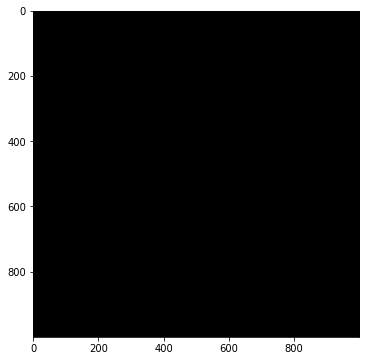

In [11]:
MAP_SIZE_X = int(MAP_WIDTH/RESOLUTION)
MAP_SIZE_Y = int(MAP_WIDTH/RESOLUTION)
ogm_time_0 = np.ones((MAP_SIZE_Y,MAP_SIZE_X)) * 0.5

xarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
yarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
MAP_XX, MAP_YY = np.meshgrid(xarr, -yarr)
rgrid = np.sqrt(np.add(np.square(MAP_XX),np.square(MAP_YY)))
OOR_MASK = rgrid >= MAX_RANGE

lidar_ogm = lidar_nonroad[:,[2,0]]
lidar_ogm1 = lidar_nonroad1[:,[2,0]]

plt.figure(figsize=(6, 6))
plt.imshow(ogm_time_0,cmap='gray')
plt.show()

## Generate Measurement Grid from Filtered LiDAR

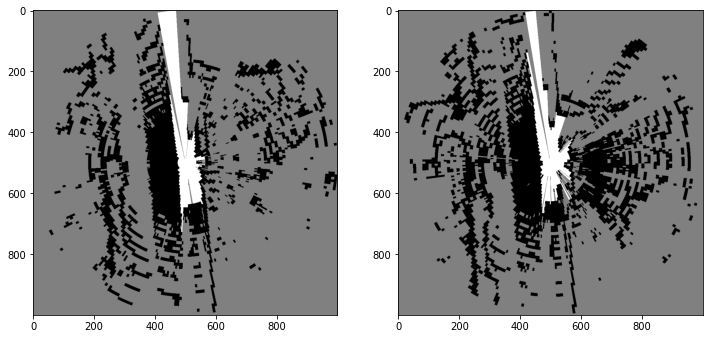

In [12]:
def generate_measurement_ogm(lidar_in,ogm_shape):
  rphi_meas = np.zeros((lidar_in.shape[0],2))
  rphi_meas[:,1] = np.sqrt(np.add(np.square(lidar_in[:,0]),np.square(lidar_in[:,1])))/ALPHA
  rphi_meas[:,0] = (np.arctan2(lidar_in[:,1],lidar_in[:,0])+np.pi)/BHETA
  rphi_meas = np.unique(rphi_meas.astype(int),axis=0)
  rphi_meas = rphi_meas[rphi_meas[:,1]<int(MAX_RANGE/ALPHA),:]
  rphi_meas = rphi_meas[rphi_meas[:,0]<int(2*np.pi/BHETA),:]

  sg_ang_bin = int(2*np.pi/BHETA)
  sg_rng_bin = int(MAX_RANGE/ALPHA)
  scan_grid = np.ones((sg_ang_bin,sg_rng_bin))*0.5
  scan_grid[tuple(rphi_meas.T)] = 0.7
  
  for ang in range(sg_ang_bin):
    ang_arr = rphi_meas[rphi_meas[:,0]==ang,1]
    if len(ang_arr) == 0:
      scan_grid[ang,:] = 0.3
    else:
      min_r = np.min(ang_arr)
      scan_grid[ang,:min_r] = 0.3
  
  ogm_sz = (ogm_shape[1],ogm_shape[0])
  ogm_cen = (int(ogm_shape[1]/2),int(ogm_shape[0]/2))
  radius = (MAX_RANGE/RESOLUTION) + SPHERICAL2CARTESIAN_BIAS
  ogm_step = cv2.warpPolar(scan_grid,ogm_sz,ogm_cen,radius,cv2.WARP_INVERSE_MAP)
  ogm_step[OOR_MASK] = 0.5
  ogm_step = cv2.rotate(ogm_step, cv2.ROTATE_90_CLOCKWISE)
  return ogm_step

ogm_step = generate_measurement_ogm(lidar_ogm,ogm_time_0.shape)
ogm_step1 = generate_measurement_ogm(lidar_ogm1,ogm_time_0.shape)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((1-ogm_step)*255).astype(np.uint8),cmap='gray')
axs[1].imshow(((1-ogm_step1)*255).astype(np.uint8),cmap='gray')
plt.show()

## Try First Update

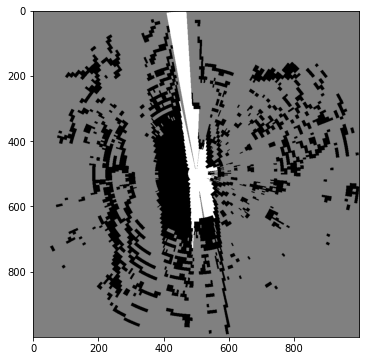

In [13]:
def logit(m):
  return np.log(np.divide(m, np.subtract(1, m)))

def inverse_logit(m):
  return np.divide(np.exp(m),np.add(1,np.exp(m)))

def update_ogm(prior_ogm,new_ogm):
  logit_map = logit(new_ogm) + logit(prior_ogm)
  out_ogm = inverse_logit(logit_map)
  out_ogm[out_ogm>=0.98] = 0.98
  out_ogm[out_ogm<=0.02] = 0.02
  return out_ogm

ogm_time_1 = update_ogm(ogm_step,ogm_time_0)

### Visualize
fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.imshow(((1-ogm_time_1)*255).astype(np.uint8),cmap='gray')
plt.show()

## Load Vehicle's Poses

In [14]:
### Load the vehicle's pose based on velocity data
def load_vehicle_pose_vel(data,idx,old_pose,old_idx):
  delta_t = (data.timestamps[idx]-data.timestamps[old_idx]).total_seconds()
  packet = data.oxts[idx].packet
  vf = packet.vf
  vr = -packet.vl
  pose_f = old_pose[0] + (vf*delta_t)
  pose_r = old_pose[1] + (vr*delta_t)
  pose_y = packet.yaw - data.oxts[0].packet.yaw
  return (pose_f,pose_r,pose_y)


pose = load_vehicle_pose_vel(data,idx,(0,0,0),idx)
pose1 = load_vehicle_pose_vel(data,idx1,pose,idx)

## Shift the OGM

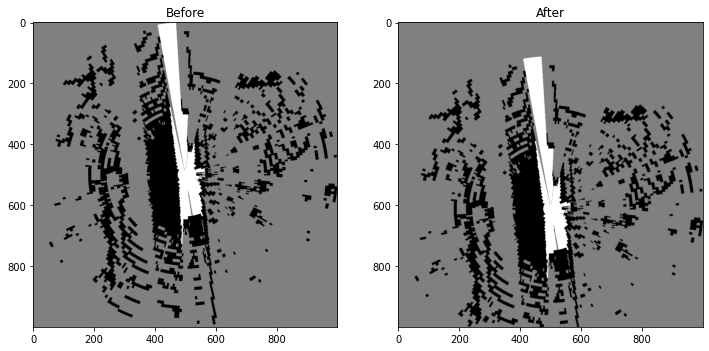

In [15]:
# Shift the map according the vehicle's poses
def shift_pose_ogm(ogm, init, fin):
  ogm_o = ogm.copy()
  theta = init[2] /180 * np.pi
  rot_m = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
  trs_m = np.array([[init[0]],[init[1]]])
  point = np.array(fin[:2]).reshape((-1,1))
  point_1 = (point - trs_m)
  point_2 = np.dot(rot_m,-point_1)
  delta_theta = (fin[2] - init[2])
  delta = np.array([point_2[1,0]/RESOLUTION,point_2[0,0]/RESOLUTION,0])

  M = np.array([[1,0,delta[0]],[0,1,-delta[1]]])
  dst = cv2.warpAffine(ogm_o,M,(ogm_o.shape[1],ogm_o.shape[0]),borderValue=0.5)
  M = cv2.getRotationMatrix2D((ogm_o.shape[1]/2+0.5,ogm_o.shape[0]/2+0.5),delta_theta,1)
  dst = cv2.warpAffine(dst,M,(ogm_o.shape[1],ogm_o.shape[0]),borderValue=0.5)
  return dst

shift_ogm_time_1 = shift_pose_ogm(ogm_time_1,pose,pose1)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((1-ogm_time_1)*255).astype(np.uint8),cmap='gray')
axs[0].set_title('Before')
axs[1].imshow(((1-shift_ogm_time_1)*255).astype(np.uint8),cmap='gray')
axs[1].set_title('After')
plt.show()

## Try Second Update

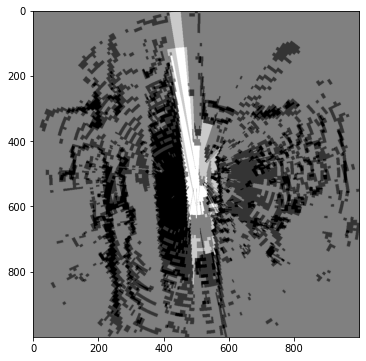

In [16]:
ogm_time_2 = update_ogm(ogm_step1,shift_ogm_time_1)

### Visualize
fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.imshow(((1-ogm_time_2)*255).astype(np.uint8),cmap='gray')
plt.show()

# MAPPING (DGM)

## Parameters

In [17]:
ALPHA = 1
BHETA = 1*np.pi/180
RESOLUTION = 0.1
MAX_RANGE = 50
MAP_WIDTH = 100
SPHERICAL2CARTESIAN_BIAS = 6
FREE_CONF = 0.7
OCC_CONF = 0.7
DYNAMIC_THRESHOLD = 0.1

## Map Initialization

In [18]:
'''
DGM Channel:
Channel 0 = {F,O}
Channel 1 = O
Channel 2 = F
'''
MAP_SIZE_X = int(MAP_WIDTH/RESOLUTION)
MAP_SIZE_Y = int(MAP_WIDTH/RESOLUTION)
dgm_time_0 = np.zeros((MAP_SIZE_Y,MAP_SIZE_X,3))
dgm_time_0[:,:,0] = 1 

xarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
yarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
MAP_XX, MAP_YY = np.meshgrid(xarr, -yarr)
rgrid = np.sqrt(np.add(np.square(MAP_XX),np.square(MAP_YY)))
OOR_MASK = rgrid >= MAX_RANGE

lidar_dgm = lidar_nonroad[:,[2,0]]
lidar_dgm1 = lidar_nonroad1[:,[2,0]]

## Generate Measurement Grid from Filtered LiDAR

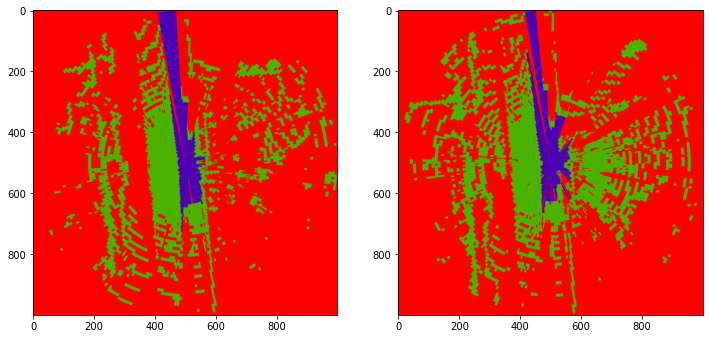

In [19]:
def generate_measurement_dgm(lidar_in,dgm_shape):
  rphi_meas = np.zeros((lidar_in.shape[0],2))
  rphi_meas[:,1] = np.sqrt(np.add(np.square(lidar_in[:,0]),np.square(lidar_in[:,1])))/ALPHA
  rphi_meas[:,0] = (np.arctan2(lidar_in[:,1],lidar_in[:,0])+np.pi)/BHETA
  rphi_meas = np.unique(rphi_meas.astype(int),axis=0)
  rphi_meas = rphi_meas[rphi_meas[:,1]<int(MAX_RANGE/ALPHA),:]
  rphi_meas = rphi_meas[rphi_meas[:,0]<int(2*np.pi/BHETA),:]

  sg_ang_bin = int(2*np.pi/BHETA)
  sg_rng_bin = int(MAX_RANGE/ALPHA)
  scan_grid = np.zeros((sg_ang_bin,sg_rng_bin,3))
  scan_grid[:,:,0] = 1 
  scan_grid[tuple(rphi_meas.T)] = (1-OCC_CONF,OCC_CONF,0)
  
  for ang in range(sg_ang_bin):
    ang_arr = rphi_meas[rphi_meas[:,0]==ang,1]
    if len(ang_arr) == 0:
      scan_grid[ang,:] = (1-FREE_CONF,0,FREE_CONF)
    else:
      min_r = np.min(ang_arr)
      scan_grid[ang,:min_r] = (1-FREE_CONF,0,FREE_CONF)
  
  dgm_sz = (dgm_shape[1],dgm_shape[0])
  dgm_cen = (int(dgm_shape[1]/2),int(dgm_shape[0]/2))
  radius = (MAX_RANGE/RESOLUTION) + SPHERICAL2CARTESIAN_BIAS
  dgm_step = cv2.warpPolar(scan_grid,dgm_sz,dgm_cen,radius,cv2.WARP_INVERSE_MAP)
  dgm_step[OOR_MASK] = (1,0,0)
  dgm_step = cv2.rotate(dgm_step, cv2.ROTATE_90_CLOCKWISE)
  return dgm_step

dgm_step = generate_measurement_dgm(lidar_dgm,dgm_time_0.shape)
dgm_step1 = generate_measurement_dgm(lidar_dgm1,dgm_time_0.shape)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow((dgm_step*255).astype(np.uint8))
axs[1].imshow((dgm_step1*255).astype(np.uint8))
plt.show()

## Try First Update

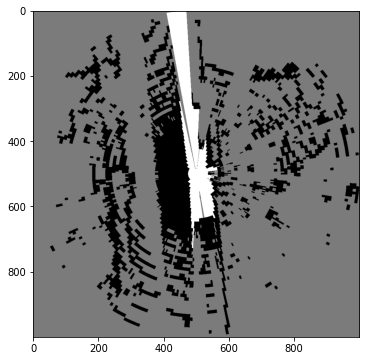

In [20]:
def update_dgm(prior_dgm,new_dgm):
  conflict_mass = np.multiply(prior_dgm[:,:,2],new_dgm[:,:,1])
  conflict_mass = np.add(conflict_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,2]))

  free_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,2])
  free_mass = np.add(free_mass,np.multiply(prior_dgm[:,:,2],new_dgm[:,:,0]))
  free_mass = np.add(free_mass,np.multiply(prior_dgm[:,:,2],new_dgm[:,:,2]))
  free_mass = np.divide(free_mass,1-conflict_mass)

  occ_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,1])
  occ_mass = np.add(occ_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,0]))
  occ_mass = np.add(occ_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,1]))
  occ_mass = np.divide(occ_mass,1-conflict_mass)

  unknown_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,0])
  unknown_mass = np.divide(unknown_mass,1-conflict_mass)

  updated_dgm = np.stack((unknown_mass,occ_mass,free_mass),axis=2)
  return updated_dgm,conflict_mass

def predict_dgm(dgm,dynamic_mass):
  max_mass = np.argmax(dgm,axis=2)
  pred_map = np.zeros(dgm.shape)
  pred_map[max_mass==0] = (123,123,123)
  pred_map[max_mass==1] = (0,0,0)
  pred_map[max_mass==2] = (255,255,255)
  pred_map[dynamic_mass>=DYNAMIC_THRESHOLD] = (0,0,255)
  return pred_map.astype(np.uint8)

dgm_time_1,dynamic_mass_1 = update_dgm(dgm_time_0,dgm_step)
dgm_pred_1 = predict_dgm(dgm_time_1,dynamic_mass_1)

fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.imshow(dgm_pred_1)
plt.show()

## Load Vehicle's Pose

In [21]:
### Load the vehicle's pose based on velocity data
def load_vehicle_pose_vel(data,idx,old_pose,old_idx):
  delta_t = (data.timestamps[idx]-data.timestamps[old_idx]).total_seconds()
  packet = data.oxts[idx].packet
  vf = packet.vf
  vr = -packet.vl
  pose_f = old_pose[0] + (vf*delta_t)
  pose_r = old_pose[1] + (vr*delta_t)
  pose_y = packet.yaw - data.oxts[0].packet.yaw
  return (pose_f,pose_r,pose_y)


pose = load_vehicle_pose_vel(data,idx,(0,0,0),idx)
pose1 = load_vehicle_pose_vel(data,idx1,pose,idx)

## Shift the DGM

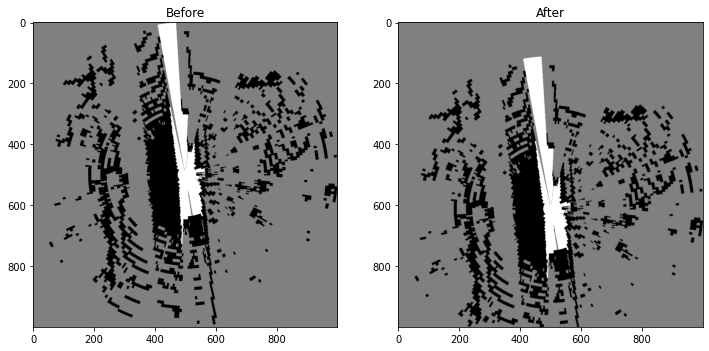

In [22]:
# Shift the map according the vehicle's poses
def shift_pose_dgm(dgm, init, fin):
  dgm_o = dgm.copy()
  theta = init[2] /180 * np.pi
  rot_m = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
  trs_m = np.array([[init[0]],[init[1]]])
  point = np.array(fin[:2]).reshape((-1,1))
  point_1 = (point - trs_m)
  point_2 = np.dot(rot_m,-point_1)
  delta_theta = (fin[2] - init[2])
  delta = np.array([point_2[1,0]/RESOLUTION,point_2[0,0]/RESOLUTION,0])

  M = np.array([[1,0,delta[0]],[0,1,-delta[1]]])
  dst = cv2.warpAffine(dgm_o,M,(dgm_o.shape[1],dgm_o.shape[0]),borderValue=0.5)
  M = cv2.getRotationMatrix2D((dgm_o.shape[1]/2+0.5,dgm_o.shape[0]/2+0.5),delta_theta,1)
  dst = cv2.warpAffine(dst,M,(dgm_o.shape[1],dgm_o.shape[0]),borderValue=0.5)
  return dst

shift_dgm_time_1 = shift_pose_dgm(dgm_time_1,pose,pose1)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((1-ogm_time_1)*255).astype(np.uint8),cmap='gray')
axs[0].set_title('Before')
axs[1].imshow(((1-shift_ogm_time_1)*255).astype(np.uint8),cmap='gray')
axs[1].set_title('After')
plt.show()

## The Second Update

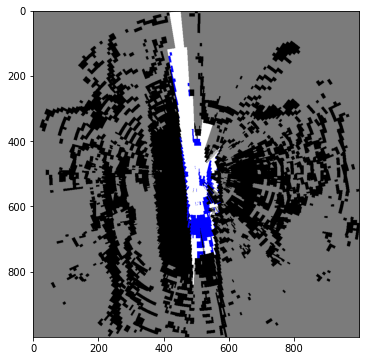

In [23]:
dgm_time_2,dynamic_mass_2 = update_dgm(shift_dgm_time_1,dgm_step1)
dgm_pred_2 = predict_dgm(dgm_time_2,dynamic_mass_2)

fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.imshow(dgm_pred_2)
plt.show()